# Comparisons of numerical phenology models and machine learning methods on predicting the spring onset of natural vegetation across the Northern Hemisphere

From this paper: https://www.sciencedirect.com/science/article/pii/S1470160X21007913
<br>
Phenological observations for **Deciduous broadleaf forests (DBF)** from **NPN network** in the period of **2007 to 2017**
<br>
 

In [1]:
from springtime.datasets.daymet import DaymetSinglePoint, DaymetMultiplePoints

In [2]:
from pyPhenology import models, utils
import numpy as np

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math
from shapely import wkt
from datetime import datetime

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [5]:
from merf import MERF

## Data preparation

In [6]:
df = pd.read_csv("combined_DBF.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, crs='epsg:4326')
df.head()

,Unnamed: 0,site_id,elevation_in_meters,state,species_id,genus,species,common_name,kingdom,individual_id,...,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry
0,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,144,2454245,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820)
1,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,151,2454252,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820)
2,3,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4101,...,144,2454245,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820)
3,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,136,2454602,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820)
4,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,136,2454602,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820)


In [7]:
print("We have",df.shape[0], "observations")
print("The observations are from",df['last_yes_year'].min(),"to",df['last_yes_year'].max())

We have 5059 observations
The observations are from 2007 to 2017


<Axes: >

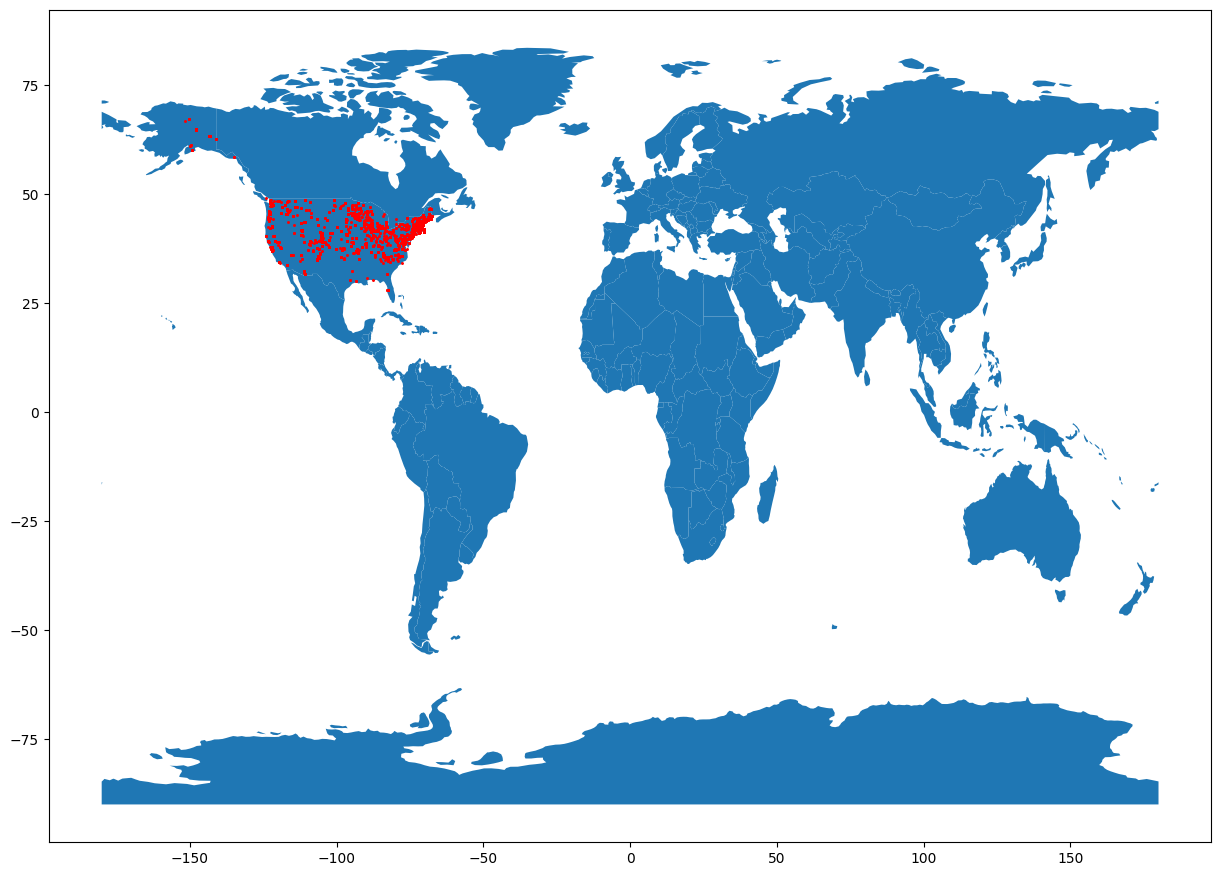

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df.plot(ax=world.plot(figsize=(15, 15)), marker='.', color='red', markersize=5)

In [9]:
df['lat'] = df.geometry.apply(lambda p: p.y)
df['lon'] = df.geometry.apply(lambda p: p.x)
df

,Unnamed: 0,site_id,elevation_in_meters,state,species_id,genus,species,common_name,kingdom,individual_id,...,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon
0,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
1,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
2,3,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4101,...,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
3,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
4,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820),45.568195,-116.973862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,296,27639,145,NH,36,Syringa,vulgaris,common lilac,Plantae,143257,...,85,2017,12,7,341,2458095,-9999,POINT (-72.26594 42.92350),42.923504,-72.265938
5055,297,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143328,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987
5056,298,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143340,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987
5057,299,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143341,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987


In [10]:
df.columns

Index(['Unnamed: 0', 'site_id', 'elevation_in_meters', 'state', 'species_id',
       'genus', 'species', 'common_name', 'kingdom', 'individual_id',
       'phenophase_id', 'phenophase_description', 'first_yes_year',
       'first_yes_month', 'first_yes_day', 'first_yes_doy',
       'first_yes_julian_date', 'numdays_since_prior_no', 'last_yes_year',
       'last_yes_month', 'last_yes_day', 'last_yes_doy',
       'last_yes_julian_date', 'numdays_until_next_no', 'geometry', 'lat',
       'lon'],
      dtype='object')

In [11]:
df = df.drop(columns = ['elevation_in_meters', 'state','species_id', 'genus','species','common_name','kingdom','individual_id','phenophase_description'])

In [12]:
def format_timestamp(x):
    date_string = str(int(x.first_yes_year)) + '-'+ str(int( x.first_yes_month)) + '-'+  str(int(x.first_yes_day))
    date_object = datetime.strptime(date_string, "%Y-%m-%d")
    return date_object

In [13]:
df['timestamp'] = df.apply(format_timestamp, axis = 1)
df.head()

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp
0,1,5533,371,2007,5,24,144,2454245,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24
1,2,5533,371,2007,5,31,151,2454252,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-31
2,3,5533,371,2007,5,24,144,2454245,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24
3,1,5533,371,2008,5,15,136,2454602,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15
4,2,5533,371,2008,5,15,136,2454602,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15


In [14]:
# compute only one doy per site_id and year (all the phenophases related to the spring onset)
df['mean_doy'] = df.groupby(['site_id', 'first_yes_year'])['first_yes_doy'].transform(lambda x: x.mean())
df

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp,mean_doy
0,1,5533,371,2007,5,24,144,2454245,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24,145.75
1,2,5533,371,2007,5,31,151,2454252,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-31,145.75
2,3,5533,371,2007,5,24,144,2454245,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24,145.75
3,1,5533,371,2008,5,15,136,2454602,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15,136.00
4,2,5533,371,2008,5,15,136,2454602,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15,136.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,296,27639,373,2017,12,7,341,2458095,85,2017,12,7,341,2458095,-9999,POINT (-72.26594 42.92350),42.923504,-72.265938,2017-12-07,341.00
5055,297,27659,373,2017,11,30,334,2458088,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987,2017-11-30,334.00
5056,298,27659,373,2017,11,30,334,2458088,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987,2017-11-30,334.00
5057,299,27659,373,2017,11,30,334,2458088,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987,2017-11-30,334.00


In [15]:
df['mean_doy'] = df['mean_doy'].apply(lambda x: round(x,0))
df.head()

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp,mean_doy
0,1,5533,371,2007,5,24,144,2454245,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24,146.0
1,2,5533,371,2007,5,31,151,2454252,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-31,146.0
2,3,5533,371,2007,5,24,144,2454245,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2007-05-24,146.0
3,1,5533,371,2008,5,15,136,2454602,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15,136.0
4,2,5533,371,2008,5,15,136,2454602,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820),45.568195,-116.973862,2008-05-15,136.0


In [16]:
#sorting data/ later drop duplicates will keep the first
df = df.sort_values(['site_id','timestamp'])
df

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp,mean_doy
1038,11,2,371,2009,4,4,94,2454926,4,2009,5,2,122,2454954,36,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-04-04,113.0
3365,89,2,373,2009,4,15,105,2454937,6,2009,4,19,109,2454941,26,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-04-15,113.0
3288,12,2,373,2009,4,16,106,2454938,1,2009,4,19,109,2454941,30,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-04-16,113.0
2824,2,2,371,2009,5,2,122,2454954,13,2009,5,2,122,2454954,36,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-05-02,113.0
2857,35,2,371,2009,5,2,122,2454954,13,2009,5,2,122,2454954,36,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-05-02,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,123,35924,371,2017,5,17,137,2457891,5,2017,5,24,144,2457898,2,POINT (-89.54215 46.23197),46.231968,-89.542152,2017-05-17,134.0
1024,132,35924,371,2017,5,17,137,2457891,5,2017,5,24,144,2457898,2,POINT (-89.54215 46.23197),46.231968,-89.542152,2017-05-17,134.0
1007,115,35924,371,2017,5,19,139,2457893,2,2017,5,29,149,2457903,2,POINT (-89.54215 46.23197),46.231968,-89.542152,2017-05-19,134.0
1020,128,35924,371,2017,5,22,142,2457896,3,2017,6,2,153,2457907,3,POINT (-89.54215 46.23197),46.231968,-89.542152,2017-05-22,134.0


In [17]:
df_clean = df.drop_duplicates(subset=['site_id','first_yes_year'])
df_clean

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp,mean_doy
1038,11,2,371,2009,4,4,94,2454926,4,2009,5,2,122,2454954,36,POINT (-70.69133 43.08535),43.085350,-70.691330,2009-04-04,113.0
1057,5,2,371,2010,3,20,79,2455276,7,2010,5,5,125,2455322,5,POINT (-70.69133 43.08535),43.085350,-70.691330,2010-03-20,100.0
1077,1,2,371,2011,4,14,104,2455666,4,2011,4,27,117,2455679,15,POINT (-70.69133 43.08535),43.085350,-70.691330,2011-04-14,111.0
3801,9,2,373,2012,3,23,83,2456010,1,2012,4,8,99,2456026,3,POINT (-70.69133 43.08535),43.085350,-70.691330,2012-03-23,90.0
3977,8,2,373,2013,4,17,107,2456400,1,2013,5,6,126,2456419,7,POINT (-70.69133 43.08535),43.085350,-70.691330,2013-04-17,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,86,35914,371,2016,5,6,127,2457515,2,2016,5,11,132,2457520,2,POINT (-89.58568 45.50487),45.504875,-89.585678,2016-05-06,132.0
992,100,35914,371,2017,4,24,114,2457868,7,2017,5,3,123,2457877,2,POINT (-89.58568 45.50487),45.504875,-89.585678,2017-04-24,133.0
767,86,35924,371,2015,5,1,121,2457144,2,2015,5,1,121,2457144,3,POINT (-89.54215 46.23197),46.231968,-89.542152,2015-05-01,126.0
876,98,35924,371,2016,4,9,100,2457488,11,2016,4,9,100,2457488,6,POINT (-89.54215 46.23197),46.231968,-89.542152,2016-04-09,123.0


In [18]:
# take random 100 observations
obs_data = df_clean.sample(n=100)
obs_data

,Unnamed: 0,site_id,phenophase_id,first_yes_year,first_yes_month,first_yes_day,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon,timestamp,mean_doy
3279,3,9,373,2009,4,9,99,2454931,1,2009,4,20,110,2454942,4,POINT (-87.89300 43.09780),43.097801,-87.892998,2009-04-09,105.0
3431,155,272,373,2009,3,6,65,2454897,-9999,2009,3,6,65,2454897,41,POINT (-108.90000 39.30000),39.299999,-108.900002,2009-03-06,84.0
3665,15,847,373,2011,4,3,93,2455655,7,2011,4,11,101,2455663,-9999,POINT (-87.79898 41.86990),41.869896,-87.798981,2011-04-03,93.0
2969,35,5434,371,2011,4,26,116,2455678,3,2011,5,3,123,2455685,7,POINT (-70.40681 43.63101),43.631012,-70.406815,2011-04-26,116.0
4814,56,1191,373,2017,4,19,109,2457863,5,2017,5,30,150,2457904,-9999,POINT (-87.95583 42.25259),42.252590,-87.955826,2017-04-19,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,7,418,373,2011,3,14,73,2455635,-9999,2011,3,14,73,2455635,7,POINT (-76.55337 38.88813),38.888126,-76.553368,2011-03-14,141.0
1872,83,130,373,2010,4,19,109,2455306,5,2010,5,3,123,2455320,7,POINT (-93.49281 47.24176),47.241760,-93.492805,2010-04-19,112.0
2107,96,5151,373,2012,3,25,85,2456012,-9999,2012,3,25,85,2456012,-9999,POINT (-88.29793 41.34128),41.341278,-88.297935,2012-03-25,85.0
2168,36,1826,373,2013,4,7,97,2456390,6,2013,4,8,98,2456391,12,POINT (-73.87393 40.85976),40.859764,-73.873932,2013-04-07,97.0


In [19]:
# from shapely.geometry import Point
# obs_data['geometry'] = [Point(xy) for xy in zip(obs_data.lon, obs_data.lat)]
# obs_data

In [20]:
# we need the site_id too. So maybe better zip(df1.site_id,df1.lon, df1.lat)
dataset = DaymetMultiplePoints(points=list(zip(obs_data.lon, obs_data.lat)), years=[2007, 2017])
dataset

DaymetMultiplePoints(dataset='daymet_multiple_points', points=[(-87.892998, 43.097801), (-108.900002, 39.299999), (-87.798981, 41.869896), (-70.406815, 43.631012), (-87.955826, 42.25259), (-71.440529, 43.854237), (-70.69133, 43.08535), (-85.633453, 38.25729), (-69.985458, 44.42337), (-81.693153, 41.433689), (-87.798981, 41.869896), (-98.695633, 46.899017), (-83.303322, 35.510715), (-79.415192, 39.06464), (-84.595879, 42.703114), (-147.880295, 64.925751), (-72.599998, 43.380001), (-98.705498, 46.908852), (-71.362434, 42.293243), (-87.70285, 41.913803), (-84.513054, 39.145248), (-79.689758, 39.36087), (-92.751999, 36.524502), (-81.633675, 34.477066), (-112.056061, 36.204147), (-93.795433, 42.929218), (-96.782646, 44.314655), (-93.470726, 47.515331), (-73.947464, 44.272942), (-71.440529, 43.854237), (-87.783676, 44.085667), (-81.725487, 41.238537), (-105.917198, 35.518261), (-73.220451, 41.972836), (-79.418045, 39.063416), (-88.381523, 42.186203), (-78.619591, 42.763412), (-105.076782, 40

In [21]:
dataset.download()
tempdata = dataset.load()
tempdata


R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-108.900002_39.299999",
+             lat = 39.299999,
+             lon = -108.900002,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             internal = 


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.406815_43.631012",
+             lat = 43.631012,
+             lon = -70.406815,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-69.985458_44.42337",
+             lat = 44.42337,
+             lon = -69.985458,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-98.695633_46.899017",
+             lat = 46.899017,
+             lon = -98.695633,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-79.415192_39.06464",
+             lat = 39.06464,
+             lon = -79.415192,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-84.595879_42.703114",
+             lat = 42.703114,
+             lon = -84.595879,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-147.880295_64.925751",
+             lat = 64.925751,
+             lon = -147.880295,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-98.705498_46.908852",
+             lat = 46.908852,
+             lon = -98.705498,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-71.362434_42.293243",
+             lat = 42.293243,
+             lon = -71.362434,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-87.70285_41.913803",
+             lat = 41.913803,
+             lon = -87.70285,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-84.513054_39.145248",
+             lat = 39.145248,
+             lon = -84.513054,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-79.689758_39.36087",
+             lat = 39.36087,
+             lon = -79.689758,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-81.633675_34.477066",
+             lat = 34.477066,
+             lon = -81.633675,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-112.056061_36.204147",
+             lat = 36.204147,
+             lon = -112.056061,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.782646_44.314655",
+             lat = 44.314655,
+             lon = -96.782646,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-93.470726_47.515331",
+             lat = 47.515331,
+             lon = -93.470726,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.947464_44.272942",
+             lat = 44.272942,
+             lon = -73.947464,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-87.783676_44.085667",
+             lat = 44.085667,
+             lon = -87.783676,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-81.725487_41.238537",
+             lat = 41.238537,
+             lon = -81.725487,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-79.418045_39.063416",
+             lat = 39.063416,
+             lon = -79.418045,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-88.381523_42.186203",
+             lat = 42.186203,
+             lon = -88.381523,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-78.619591_42.763412",
+             lat = 42.763412,
+             lon = -78.619591,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-105.076782_40.199249",
+             lat = 40.199249,
+             lon = -105.076782,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-114.850861_45.101624",
+             lat = 45.101624,
+             lon = -114.850861,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-77.024651_39.394035",
+             lat = 39.394035,
+             lon = -77.024651,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-81.145103_41.480873",
+             lat = 41.480873,
+             lon = -81.145103,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-99.855309_42.553192",
+             lat = 42.553192,
+             lon = -99.855309,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.78257_44.314625",
+             lat = 44.314625,
+             lon = -96.78257,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-118.804436_45.650951",
+             lat = 45.650951,
+             lon = -118.804436,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.176582_41.290379",
+             lat = 41.290379,
+             lon = -70.176582,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.873741_42.219055",
+             lat = 42.219055,
+             lon = -73.873741,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-114.972984_36.055347",
+             lat = 36.055347,
+             lon = -114.972984,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-143.038651_63.323421",
+             lat = 63.323421,
+             lon = -143.038651,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-122.074013_42.705845",
+             lat = 42.705845,
+             lon = -122.074013,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-122.689301_42.192146",
+             lat = 42.192146,
+             lon = -122.689301,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-95.547943_42.489243",
+             lat = 42.489243,
+             lon = -95.547943,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-67.898643_46.614246",
+             lat = 46.614246,
+             lon = -67.898643,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.885437_40.75375",
+             lat = 40.75375,
+             lon = -73.885437,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-106.624191_35.082458",
+             lat = 35.082458,
+             lon = -106.624191,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-88.022522_43.387383",
+             lat = 43.387383,
+             lon = -88.022522,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-85.242989_39.367615",
+             lat = 39.367615,
+             lon = -85.242989,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-90.562172_43.164249",
+             lat = 43.164249,
+             lon = -90.562172,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-104.89093_39.498241",
+             lat = 39.498241,
+             lon = -104.89093,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-105.96991_35.639633",
+             lat = 35.639633,
+             lon = -105.96991,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-104.87365_39.667038",
+             lat = 39.667038,
+             lon = -104.87365,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-78.72068_35.903923",
+             lat = 35.903923,
+             lon = -78.72068,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.782631_44.314629",
+             lat = 44.314629,
+             lon = -96.782631,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-77.362717_38.947868",
+             lat = 38.947868,
+             lon = -77.362717,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.433449_42.936153",
+             lat = 42.936153,
+             lon = -73.433449,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.784554_44.315334",
+             lat = 44.315334,
+             lon = -96.784554,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-77.080002_43.0",
+             lat = 43.0,
+             lon = -77.080002,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             internal 


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-87.878204_43.081448",
+             lat = 43.081448,
+             lon = -87.878204,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.784233_44.317989",
+             lat = 44.317989,
+             lon = -96.784233,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-82.993546_39.346977",
+             lat = 39.346977,
+             lon = -82.993546,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-113.634499_47.219101",
+             lat = 47.219101,
+             lon = -113.634499,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-105.099319_39.550663",
+             lat = 39.550663,
+             lon = -105.099319,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-96.784416_44.316689",
+             lat = 44.316689,
+             lon = -96.784416,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-100.726822_48.614853",
+             lat = 48.614853,
+             lon = -100.726822,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+          


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.878189_40.860519",
+             lat = 40.860519,
+             lon = -73.878189,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-88.101791_42.997086",
+             lat = 42.997086,
+             lon = -88.101791,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-94.83091_39.930405",
+             lat = 39.930405,
+             lon = -94.83091,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-92.913094_45.339485",
+             lat = 45.339485,
+             lon = -92.913094,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-76.5513_40.414211",
+             lat = 40.414211,
+             lon = -76.5513,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             int


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-80.857506_35.182804",
+             lat = 35.182804,
+             lon = -80.857506,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-76.553368_38.888126",
+             lat = 38.888126,
+             lon = -76.553368,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-93.492805_47.24176",
+             lat = 47.24176,
+             lon = -93.492805,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             i


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-88.297935_41.341278",
+             lat = 41.341278,
+             lon = -88.297935,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-73.873932_40.859764",
+             lat = 40.859764,
+             lon = -73.873932,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-75.388504_39.999107",
+             lat = 39.999107,
+             lon = -75.388504,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 


,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry
0,2007,1,31955.08,0.0,154.08,55.51,6.19,0.51,633.55,-87.892998,43.097801,POINT (-87.89300 43.09780)
1,2007,2,32001.91,0.0,205.04,53.88,6.24,-2.14,521.99,-87.892998,43.097801,POINT (-87.89300 43.09780)
2,2007,3,32052.56,0.0,234.74,51.89,10.05,-1.25,557.52,-87.892998,43.097801,POINT (-87.89300 43.09780)
3,2007,4,32106.99,0.0,204.06,48.56,10.40,1.91,701.11,-87.892998,43.097801,POINT (-87.89300 43.09780)
4,2007,5,32165.17,0.0,172.16,44.34,10.69,4.06,816.15,-87.892998,43.097801,POINT (-87.89300 43.09780)
...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2017,361,33017.90,0.0,142.37,0.00,-3.02,-8.69,317.06,-75.388504,39.999107,POINT (-75.38850 39.99911)
4011,2017,362,33041.86,0.0,162.14,0.00,-5.52,-11.92,245.17,-75.388504,39.999107,POINT (-75.38850 39.99911)
4012,2017,363,33069.32,1.0,192.70,1.00,-5.12,-11.92,245.18,-75.388504,39.999107,POINT (-75.38850 39.99911)
4013,2017,364,33100.26,1.0,200.73,1.99,-3.83,-10.90,266.14,-75.388504,39.999107,POINT (-75.38850 39.99911)


In [22]:
# we need date
tempdata["combined"] = tempdata["year"]*1000 + tempdata["yday"]
tempdata["date"] = pd.to_datetime(tempdata["combined"], format = "%Y%j")
tempdata = tempdata.drop(columns =["combined"])
tempdata.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry,date
0,2007,1,31955.08,0.0,154.08,55.51,6.19,0.51,633.55,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-01
1,2007,2,32001.91,0.0,205.04,53.88,6.24,-2.14,521.99,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-02
2,2007,3,32052.56,0.0,234.74,51.89,10.05,-1.25,557.52,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-03
3,2007,4,32106.99,0.0,204.06,48.56,10.40,1.91,701.11,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-04
4,2007,5,32165.17,0.0,172.16,44.34,10.69,4.06,816.15,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-05


In [23]:
# we need site id
tempdata = tempdata.merge(obs_data[["site_id","geometry"]], on='geometry', how='left')

# We need doy column for the pyphenology! I would use a different name...this is confusing
tempdata = tempdata.rename(columns={'yday': 'doy'})

# we need temperature
tempdata['temperature'] = (tempdata['tmax (deg c)'] + tempdata['tmin (deg c)'])/2
tempdata.head()

,year,doy,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry,date,site_id,temperature
0,2007,1,31955.08,0.0,154.08,55.51,6.19,0.51,633.55,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-01,9,3.350
1,2007,2,32001.91,0.0,205.04,53.88,6.24,-2.14,521.99,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-02,9,2.050
2,2007,3,32052.56,0.0,234.74,51.89,10.05,-1.25,557.52,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-03,9,4.400
3,2007,4,32106.99,0.0,204.06,48.56,10.40,1.91,701.11,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-04,9,6.155
4,2007,5,32165.17,0.0,172.16,44.34,10.69,4.06,816.15,-87.892998,43.097801,POINT (-87.89300 43.09780),2007-01-05,9,7.375


In [24]:
# ordered by 'site_id and date'
weather_data_raw_sorted = tempdata.sort_values(["site_id", "date"])
weather_data_raw_sorted

,year,doy,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry,date,site_id,temperature
36135,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,336.30,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-01,2,-0.720
36136,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,704.60,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-02,2,3.805
36137,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,484.89,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-03,2,3.615
36138,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,588.05,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-04,2,4.770
36139,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,803.73,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-05,2,9.685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325210,2017,361,33147.19,0.00,310.29,3.35,12.59,-15.05,160.57,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-27,27143,-1.230
325211,2017,362,33170.81,0.00,266.06,3.35,11.26,-6.96,322.56,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-28,27143,2.150
325212,2017,363,33197.89,0.00,292.27,3.16,17.47,-5.54,318.48,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-29,27143,5.965
325213,2017,364,33228.41,0.00,279.83,3.16,9.56,-10.47,244.29,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-30,27143,-0.455


In [25]:
# Renaming
weather_data_raw_sorted = weather_data_raw_sorted.rename(columns={'dayl (s)': 'dayl', 'prcp (mm/day)': 'prcp', 'srad (W/m^2)': 'srad','swe (kg/m^2)': 'swe',
                                   'tmax (deg c)': 'tmax','tmin (deg c)': 'tmin', 'vp (Pa)': 'vp'})


In [26]:
# Why?
weather_data_raw_sorted = weather_data_raw_sorted.drop(columns = ['vp'])
weather_data_raw_sorted

,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,geometry,date,site_id,temperature
36135,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-01,2,-0.720
36136,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-02,2,3.805
36137,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-03,2,3.615
36138,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-04,2,4.770
36139,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-05,2,9.685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325210,2017,361,33147.19,0.00,310.29,3.35,12.59,-15.05,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-27,27143,-1.230
325211,2017,362,33170.81,0.00,266.06,3.35,11.26,-6.96,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-28,27143,2.150
325212,2017,363,33197.89,0.00,292.27,3.16,17.47,-5.54,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-29,27143,5.965
325213,2017,364,33228.41,0.00,279.83,3.16,9.56,-10.47,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-30,27143,-0.455


In [27]:
# Checking for duplicates
# Why do we have so many duplicates? because of multiple phenopahses?

print(weather_data_raw_sorted.shape)
weather_data_raw_sorted = weather_data_raw_sorted.drop_duplicates(subset=('date','site_id'))
print(weather_data_raw_sorted.shape)

(481800, 14)
(369380, 14)


In [28]:
weather_data_raw_sorted

,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,geometry,date,site_id,temperature
36135,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-01,2,-0.720
36136,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-02,2,3.805
36137,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-03,2,3.615
36138,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-04,2,4.770
36139,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,-70.69133,43.085350,POINT (-70.69133 43.08535),2007-01-05,2,9.685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325210,2017,361,33147.19,0.00,310.29,3.35,12.59,-15.05,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-27,27143,-1.230
325211,2017,362,33170.81,0.00,266.06,3.35,11.26,-6.96,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-28,27143,2.150
325212,2017,363,33197.89,0.00,292.27,3.16,17.47,-5.54,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-29,27143,5.965
325213,2017,364,33228.41,0.00,279.83,3.16,9.56,-10.47,-104.87365,39.667038,POINT (-104.87365 39.66704),2017-12-30,27143,-0.455


#### FE from weather data based on sliding window over timeseries

In [29]:
# 
# the dataframe has been prevously ordered by 'site_id and date'
# so the rolling can be done by groupping by location and then calculate the rolling ...
def compute_windows(dataframe, size):
    print('processing size: ' + str(size))
    column_index_name = str(size)
    columns_names = list(['tmax', 'tmin', 'prcp', 'srad', 'swe'])
    columns_new_names = [column_name + '_' + column_index_name for column_name in columns_names]
    combined_input_data = dataframe.groupby('site_id')[columns_names].rolling(size).mean().reset_index(0,drop=True)
    combined_input_data.columns = columns_new_names
    return combined_input_data

In [30]:
# for each size compute the windows (rolling)
partial_results_all = weather_data_raw_sorted.copy()
for size in [3,7,15,30,90,365]:
    partial_results = compute_windows(weather_data_raw_sorted, size)
    partial_results_all = pd.concat([partial_results_all,partial_results], axis = 1)
partial_results_all.tail()

processing size: 3
processing size: 7
processing size: 15
processing size: 30
processing size: 90
processing size: 365


,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,...,tmax_90,tmin_90,prcp_90,srad_90,swe_90,tmax_365,tmin_365,prcp_365,srad_365,swe_365
325210,2017,361,33147.19,0.0,310.29,3.35,12.59,-15.05,-104.87365,39.667038,...,14.945556,-1.545111,0.527333,268.315222,0.202556,19.584685,3.591973,1.127644,355.760877,0.598219
325211,2017,362,33170.81,0.0,266.06,3.35,11.26,-6.96,-104.87365,39.667038,...,14.871667,-1.689000,0.519778,267.723889,0.239778,19.580712,3.598438,1.127644,355.676959,0.587370
325212,2017,363,33197.89,0.0,292.27,3.16,17.47,-5.54,-104.87365,39.667038,...,14.819000,-1.816778,0.519778,266.649889,0.274889,19.599644,3.599973,1.127644,355.762603,0.576000
325213,2017,364,33228.41,0.0,279.83,3.16,9.56,-10.47,-104.87365,39.667038,...,14.662444,-2.009444,0.460778,266.535000,0.310000,19.600740,3.593534,1.127644,355.799973,0.564630
325214,2017,365,33262.33,0.0,157.93,3.16,-2.51,-11.18,-104.87365,39.667038,...,14.537444,-2.183889,0.400000,267.203889,0.345111,19.543644,3.571425,1.127644,355.438877,0.556575


In [31]:
partial_results_all.head(10)

,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,...,tmax_90,tmin_90,prcp_90,srad_90,swe_90,tmax_365,tmin_365,prcp_365,srad_365,swe_365
36135,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36136,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36137,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36138,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36139,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36140,2007,6,32227.04,6.41,149.40,50.52,20.76,10.25,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36141,2007,7,32292.56,9.56,163.08,47.52,12.11,1.16,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36142,2007,8,32361.69,16.91,124.03,44.49,8.27,1.20,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36143,2007,9,32434.38,0.00,162.39,42.31,5.98,-0.79,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36144,2007,10,32510.56,0.00,181.25,42.17,1.91,-5.67,-70.69133,43.08535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# remove the year-1 (2007)
weather_data_raw = partial_results_all[partial_results_all['year']>2007]
weather_data_raw.head()

,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,...,tmax_90,tmin_90,prcp_90,srad_90,swe_90,tmax_365,tmin_365,prcp_365,srad_365,swe_365
36500,2008,1,31955.08,12.92,146.36,72.47,2.00,-7.53,-70.69133,43.08535,...,8.819444,-1.030667,4.063333,186.075111,12.296000,13.928685,3.013479,3.677014,306.891315,26.260438
36501,2008,2,32001.91,0.00,206.19,72.47,0.12,-10.11,-70.69133,43.08535,...,8.514889,-1.305111,4.063333,184.936778,13.101222,13.913589,2.980356,3.677014,307.208603,26.280959
36502,2008,3,32052.56,0.00,180.61,72.47,-9.93,-18.11,-70.69133,43.08535,...,8.117111,-1.607444,4.063333,182.983556,13.906444,13.858000,2.939315,3.677014,307.051151,26.304767
36503,2008,4,32106.99,0.00,255.97,72.47,-2.68,-18.74,-70.69133,43.08535,...,7.814444,-1.958556,3.979556,183.398444,14.711667,13.823096,2.889397,3.677014,307.166356,26.334877
36504,2008,5,32165.17,0.00,232.52,72.47,2.88,-9.66,-70.69133,43.08535,...,7.663667,-2.195111,3.933889,184.757444,15.516889,13.788438,2.852411,3.675178,307.202000,26.376301


In [33]:
weather_data_raw_clean = pd.DataFrame()
weather_data_raw_clean = weather_data_raw.dropna()
weather_data_raw_clean.shape

(335800, 44)

In [34]:
weather_data_raw_clean = weather_data_raw_clean.reset_index(drop=True)
weather_data_raw_clean

,year,doy,dayl,prcp,srad,swe,tmax,tmin,x,y,...,tmax_90,tmin_90,prcp_90,srad_90,swe_90,tmax_365,tmin_365,prcp_365,srad_365,swe_365
0,2008,1,31955.08,12.92,146.36,72.47,2.00,-7.53,-70.69133,43.085350,...,8.819444,-1.030667,4.063333,186.075111,12.296000,13.928685,3.013479,3.677014,306.891315,26.260438
1,2008,2,32001.91,0.00,206.19,72.47,0.12,-10.11,-70.69133,43.085350,...,8.514889,-1.305111,4.063333,184.936778,13.101222,13.913589,2.980356,3.677014,307.208603,26.280959
2,2008,3,32052.56,0.00,180.61,72.47,-9.93,-18.11,-70.69133,43.085350,...,8.117111,-1.607444,4.063333,182.983556,13.906444,13.858000,2.939315,3.677014,307.051151,26.304767
3,2008,4,32106.99,0.00,255.97,72.47,-2.68,-18.74,-70.69133,43.085350,...,7.814444,-1.958556,3.979556,183.398444,14.711667,13.823096,2.889397,3.677014,307.166356,26.334877
4,2008,5,32165.17,0.00,232.52,72.47,2.88,-9.66,-70.69133,43.085350,...,7.663667,-2.195111,3.933889,184.757444,15.516889,13.788438,2.852411,3.675178,307.202000,26.376301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335795,2017,361,33147.19,0.00,310.29,3.35,12.59,-15.05,-104.87365,39.667038,...,14.945556,-1.545111,0.527333,268.315222,0.202556,19.584685,3.591973,1.127644,355.760877,0.598219
335796,2017,362,33170.81,0.00,266.06,3.35,11.26,-6.96,-104.87365,39.667038,...,14.871667,-1.689000,0.519778,267.723889,0.239778,19.580712,3.598438,1.127644,355.676959,0.587370
335797,2017,363,33197.89,0.00,292.27,3.16,17.47,-5.54,-104.87365,39.667038,...,14.819000,-1.816778,0.519778,266.649889,0.274889,19.599644,3.599973,1.127644,355.762603,0.576000
335798,2017,364,33228.41,0.00,279.83,3.16,9.56,-10.47,-104.87365,39.667038,...,14.662444,-2.009444,0.460778,266.535000,0.310000,19.600740,3.593534,1.127644,355.799973,0.564630


## Numerical phenology models (pyPhenology)

In [35]:
predictors = weather_data_raw_clean[['site_id','year','doy','temperature']]
observations = obs_data[['site_id','first_yes_year','timestamp','mean_doy']]
observations = observations.rename(columns={"first_yes_year": "year", "mean_doy": "doy"})

In [36]:
observations_tr = observations.iloc[0:80,:]
observations_te = observations.iloc[80:,:]
print('Training Shape:', observations_tr.shape)
print('Testing Shape:', observations_te.shape)

Training Shape: (80, 4)
Testing Shape: (20, 4)


In [37]:
model = models.ThermalTime()

In [38]:
model.fit(observations_tr, predictors)

In [39]:
model.get_params()

{'t1': 74.66551714791491, 'T': 9.929658076896436, 'F': 72.7455771890464}

In [40]:
ypred_T = model.predict(to_predict=observations_te, predictors=predictors)
ypred_T

array([142, 100, 102, 132, 104, 102, 117, 127,  98,  88,  82, 115, 105,
        83,  95,  94, 109,  78, 104,  80])

In [41]:
ytest = observations_te["doy"].values
ytest

array([126., 111.,  96., 126., 113., 103., 121., 121., 166.,  60., 107.,
       114.,  83.,  51., 103., 141., 112.,  85.,  97.,  83.])

In [42]:
print("ThermalTime Model")
print("mean_absolute_error: ", mean_absolute_error(ytest, ypred_T))
print("mean_squared_error: ", mean_squared_error(ytest, ypred_T))
print("r2: ", r2_score(ytest, ypred_T))

ThermalTime Model
mean_absolute_error:  15.5
mean_squared_error:  525.7
r2:  0.196727010187983


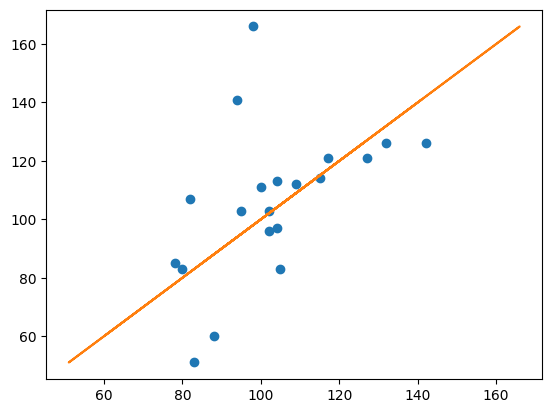

In [43]:
plt.plot(ypred_T, ytest, "o")
plt.plot(ytest, ytest, "-")

## Machine Learning models (sklearn)

In [44]:
# merge combined input data (here only weather) with observations
combined_input_data = weather_data_raw_clean
dataset_tr = combined_input_data.merge(observations_tr, how='left', left_on=['site_id','date'], right_on = ['site_id','timestamp'])
dataset_te = combined_input_data.merge(observations_te, how='left', left_on=['site_id','date'], right_on = ['site_id','timestamp'])

In [45]:
dataset_tr

,year_x,doy_x,dayl,prcp,srad,swe,tmax,tmin,x,y,...,srad_90,swe_90,tmax_365,tmin_365,prcp_365,srad_365,swe_365,year_y,timestamp,doy_y
0,2008,1,31955.08,12.92,146.36,72.47,2.00,-7.53,-70.69133,43.085350,...,186.075111,12.296000,13.928685,3.013479,3.677014,306.891315,26.260438,NaN,NaT,NaN
1,2008,2,32001.91,0.00,206.19,72.47,0.12,-10.11,-70.69133,43.085350,...,184.936778,13.101222,13.913589,2.980356,3.677014,307.208603,26.280959,NaN,NaT,NaN
2,2008,3,32052.56,0.00,180.61,72.47,-9.93,-18.11,-70.69133,43.085350,...,182.983556,13.906444,13.858000,2.939315,3.677014,307.051151,26.304767,NaN,NaT,NaN
3,2008,4,32106.99,0.00,255.97,72.47,-2.68,-18.74,-70.69133,43.085350,...,183.398444,14.711667,13.823096,2.889397,3.677014,307.166356,26.334877,NaN,NaT,NaN
4,2008,5,32165.17,0.00,232.52,72.47,2.88,-9.66,-70.69133,43.085350,...,184.757444,15.516889,13.788438,2.852411,3.675178,307.202000,26.376301,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335795,2017,361,33147.19,0.00,310.29,3.35,12.59,-15.05,-104.87365,39.667038,...,268.315222,0.202556,19.584685,3.591973,1.127644,355.760877,0.598219,NaN,NaT,NaN
335796,2017,362,33170.81,0.00,266.06,3.35,11.26,-6.96,-104.87365,39.667038,...,267.723889,0.239778,19.580712,3.598438,1.127644,355.676959,0.587370,NaN,NaT,NaN
335797,2017,363,33197.89,0.00,292.27,3.16,17.47,-5.54,-104.87365,39.667038,...,266.649889,0.274889,19.599644,3.599973,1.127644,355.762603,0.576000,NaN,NaT,NaN
335798,2017,364,33228.41,0.00,279.83,3.16,9.56,-10.47,-104.87365,39.667038,...,266.535000,0.310000,19.600740,3.593534,1.127644,355.799973,0.564630,NaN,NaT,NaN


In [46]:
# Cleaning dataset for ML
dataset_tr = dataset_tr.dropna()
dataset_te = dataset_te.dropna()
print(dataset_tr.shape)
print(dataset_te.shape)

(80, 47)
(20, 47)


In [47]:
print(dataset_tr.columns)

Index(['year_x', 'doy_x', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'x',
       'y', 'geometry', 'date', 'site_id', 'temperature', 'tmax_3', 'tmin_3',
       'prcp_3', 'srad_3', 'swe_3', 'tmax_7', 'tmin_7', 'prcp_7', 'srad_7',
       'swe_7', 'tmax_15', 'tmin_15', 'prcp_15', 'srad_15', 'swe_15',
       'tmax_30', 'tmin_30', 'prcp_30', 'srad_30', 'swe_30', 'tmax_90',
       'tmin_90', 'prcp_90', 'srad_90', 'swe_90', 'tmax_365', 'tmin_365',
       'prcp_365', 'srad_365', 'swe_365', 'year_y', 'timestamp', 'doy_y'],
      dtype='object')


In [48]:
# features
dataset_tr.columns[14:44]

Index(['tmax_3', 'tmin_3', 'prcp_3', 'srad_3', 'swe_3', 'tmax_7', 'tmin_7',
       'prcp_7', 'srad_7', 'swe_7', 'tmax_15', 'tmin_15', 'prcp_15', 'srad_15',
       'swe_15', 'tmax_30', 'tmin_30', 'prcp_30', 'srad_30', 'swe_30',
       'tmax_90', 'tmin_90', 'prcp_90', 'srad_90', 'swe_90', 'tmax_365',
       'tmin_365', 'prcp_365', 'srad_365', 'swe_365'],
      dtype='object')

In [49]:
# target
dataset_tr.columns[-1]

'doy_y'

In [50]:
# split data table into data X and target variable y
# Train/test split

xtrain = dataset_tr.iloc[:,14:44].values
ytrain = dataset_tr.iloc[:,-1].values
xtest = dataset_te.iloc[:,14:44].values
ytest = dataset_te.iloc[:,-1].values

In [51]:
print('Training Features Shape:', xtrain.shape)
print('Training Labels Shape:', ytrain.shape)
print('Testing Features Shape:', xtest.shape)
print('Testing Labels Shape:', ytest.shape)

Training Features Shape: (80, 30)
Training Labels Shape: (80,)
Testing Features Shape: (20, 30)
Testing Labels Shape: (20,)


In [52]:
ytest

array([103., 112., 126., 126., 141., 114., 121.,  97.,  83., 107.,  85.,
       166., 111., 113.,  60., 121.,  83., 103.,  96.,  51.])

In [53]:
#Feature Scaling
scaler = StandardScaler()
scaler.fit(xtrain)

xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [54]:
# Linear
lm = LinearRegression()
lm.fit(xtrain, ytrain)
ypred_lm = lm.predict(xtest)

In [55]:
print("Linear Regression Model")
print("mean_absolute_error: ", mean_absolute_error(ytest, ypred_lm))
print("mean_squared_error: ", mean_squared_error(ytest, ypred_lm))
print("r2: ", r2_score(ytest, ypred_lm))

Linear Regression Model
mean_absolute_error:  13.580509645632228
mean_squared_error:  356.8075993235795
r2:  0.45479568747137156


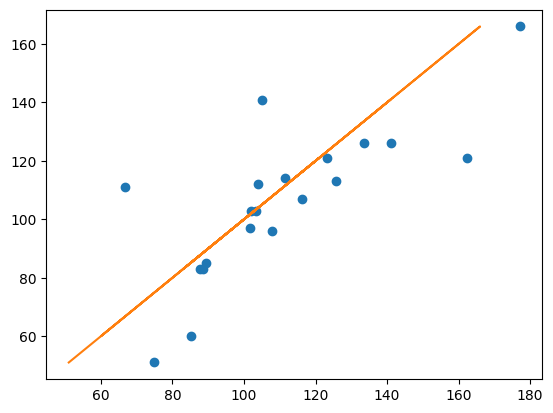

In [56]:
plt.plot(ypred_lm, ytest, "o")
plt.plot(ytest, ytest, "-")

In [57]:
# RF
rf = RandomForestRegressor(n_estimators=300)
rf.fit(xtrain, ytrain)
ypred_rf = rf.predict(xtest)

In [58]:
print("RandomForest Regression Model")
print("mean_absolute_error: ", mean_absolute_error(ytest, ypred_rf))
print("mean_squared_error: ", mean_squared_error(ytest, ypred_rf))
print("r2: ", r2_score(ytest, ypred_rf))

RandomForest Regression Model
mean_absolute_error:  15.143333333333334
mean_squared_error:  443.85296000000005
r2:  0.3217898150730194


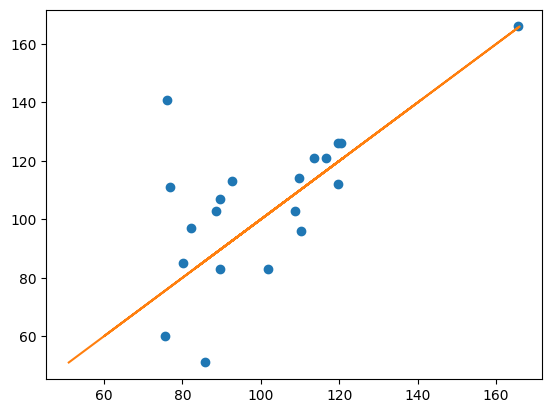

In [59]:
plt.plot(ypred_rf, ytest, "o")
plt.plot(ytest, ytest, "-")

## Mixed effect modelling (MERF)

https://pypi.org/project/merf/

https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177

In [60]:
# features
dataset_tr.columns

Index(['year_x', 'doy_x', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'x',
       'y', 'geometry', 'date', 'site_id', 'temperature', 'tmax_3', 'tmin_3',
       'prcp_3', 'srad_3', 'swe_3', 'tmax_7', 'tmin_7', 'prcp_7', 'srad_7',
       'swe_7', 'tmax_15', 'tmin_15', 'prcp_15', 'srad_15', 'swe_15',
       'tmax_30', 'tmin_30', 'prcp_30', 'srad_30', 'swe_30', 'tmax_90',
       'tmin_90', 'prcp_90', 'srad_90', 'swe_90', 'tmax_365', 'tmin_365',
       'prcp_365', 'srad_365', 'swe_365', 'year_y', 'timestamp', 'doy_y'],
      dtype='object')

In [61]:
# Random effect covariates --> they are supposed to cause clustering effect
# Fixed effects covariates --> independent features 

# For trial I select ['tmax_365','tmin_365', 'prcp_365', 'srad_365', 'swe_365'] as random effect features
# I consider the rest of the features as fixed effects covariates
# cluster_var --> 'site_id'

In [62]:
dataset_tr.columns[14:39]

Index(['tmax_3', 'tmin_3', 'prcp_3', 'srad_3', 'swe_3', 'tmax_7', 'tmin_7',
       'prcp_7', 'srad_7', 'swe_7', 'tmax_15', 'tmin_15', 'prcp_15', 'srad_15',
       'swe_15', 'tmax_30', 'tmin_30', 'prcp_30', 'srad_30', 'swe_30',
       'tmax_90', 'tmin_90', 'prcp_90', 'srad_90', 'swe_90'],
      dtype='object')

In [63]:
dataset_tr.columns[39:44]

Index(['tmax_365', 'tmin_365', 'prcp_365', 'srad_365', 'swe_365'], dtype='object')

In [64]:
dataset_tr.columns[12]

'site_id'

In [65]:
# MERF inputs are pandas df!
xtrain = dataset_tr.iloc[:,14:39]
ztrain = dataset_tr.iloc[:,39:44]
clustrain = dataset_tr.iloc[:,12]
ytrain = dataset_tr.iloc[:,-1]

xtest = dataset_te.iloc[:,14:39]
ztest = dataset_te.iloc[:,39:44]
clustest = dataset_te.iloc[:,12]
ytest = dataset_te.iloc[:,-1].values

In [66]:
merf = MERF()
merf.fit(xtrain, ztrain, clustrain, ytrain)

INFO     [merf.py:307] Training GLL is -375.35874051176575 at iteration 1.
INFO     [merf.py:307] Training GLL is -382.861617561379 at iteration 2.
INFO     [merf.py:307] Training GLL is -341.59227866458673 at iteration 3.
INFO     [merf.py:307] Training GLL is -303.58919706101267 at iteration 4.
INFO     [merf.py:307] Training GLL is -263.50852725552056 at iteration 5.
INFO     [merf.py:307] Training GLL is -233.13966256377236 at iteration 6.
INFO     [merf.py:307] Training GLL is -211.49956992325008 at iteration 7.
INFO     [merf.py:307] Training GLL is -196.2950816168427 at iteration 8.
INFO     [merf.py:307] Training GLL is -183.67033119207667 at iteration 9.
INFO     [merf.py:307] Training GLL is -174.3623225936588 at iteration 10.
INFO     [merf.py:307] Training GLL is -167.89769069051187 at iteration 11.
INFO     [merf.py:307] Training GLL is -165.32451921099283 at iteration 12.
INFO     [merf.py:307] Training GLL is -162.76019427703497 at iteration 13.
INFO     [merf.py:307] Tr

In [67]:
ypred_merf = merf.predict(xtest, ztest, clustest)

In [68]:
print("MERF Model")
print("mean_absolute_error: ", mean_absolute_error(ytest, ypred_merf))
print("mean_squared_error: ", mean_squared_error(ytest, ypred_merf))
print("r2: ", r2_score(ytest, ypred_merf))

MERF Model
mean_absolute_error:  14.827960272734936
mean_squared_error:  410.8347772453288
r2:  0.372241811229581


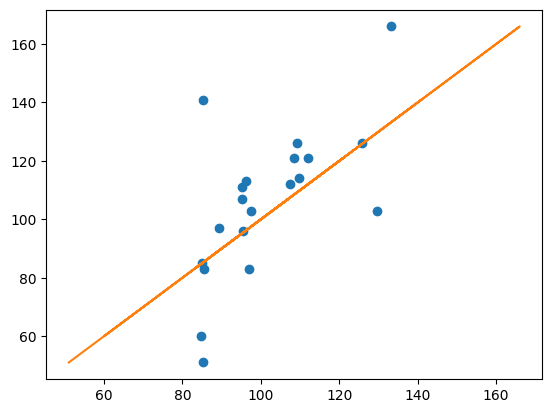

In [69]:
plt.plot(ypred_merf, ytest, "o")
plt.plot(ytest, ytest, "-")